# Chapter 7

### Inspecting and monitoring deep-learning models using Keras callbacks and TensorBoard

In this section, we’ll review ways to gain greater access to and control over what goes
on inside our model during training. Launching a training run on a large dataset for
tens of epochs using `model.fit()` or `model.fit_generator()` can be a bit like
launching a paper airplane: past the initial impulse, we don’t have any control over
its trajectory or its landing spot. 

If we want to avoid bad outcomes (and thus wasted
paper airplanes), it’s smarter to use not a paper plane, but a drone that can sense its
environment, send data back to its operator, and automatically make steering decisions based on its current state. 

The techniques we present here will transform the call
to `model.fit()` from a paper airplane into a smart, autonomous drone that can self-introspect and dynamically take action.

### Using callbacks to act on a model during training

When we’re training a model, there are many things we can’t predict from the start.
In particular, we can’t tell how many epochs will be needed to get to an optimal validation loss. The examples so far have adopted the strategy of training for enough
epochs that we begin overfitting, using the first run to figure out the proper number
of epochs to train for, and then finally launching a new training run from scratch
using this optimal number. Of course, this approach is wasteful.
 
A much better way to handle this is to stop training when we measure that the validation loss in no longer improving. This can be achieved using a **Keras callback**.

A callback is an object (a class instance implementing specific methods) that is passed to
the model in the call to fit and that is called by the model at various points during
training. 

It has access to all the available data about the state of the model and its performance, and it can take action: 
* interrupt training, 
* save a model, 
* load a different weight set, or
* otherwise alter the state of the model.

Here are some examples of ways we can use callbacks:

* `Model checkpointing`—Saving the current weights of the model at different points
during training.
* `Early stopping`—Interrupting training when the validation loss is no longer
improving (and of course, saving the best model obtained during training).
* `Dynamically adjusting the value of certain parameters during training`—Such as the
learning rate of the optimizer.
* `Logging training and validation metrics during training, or visualizing the representations learned by the model as they’re updated`—The Keras progress bar that we’re
familiar with is a callback!

The `keras.callbacks` module includes a number of built-in callbacks (this is not an
exhaustive list):

* keras.callbacks.ModelCheckpoint
* keras.callbacks.EarlyStopping
* keras.callbacks.LearningRateScheduler
* keras.callbacks.ReduceLROnPlateau
* keras.callbacks.CSVLogger

Let’s review a few of them to give us an idea of how to use them: 
* ModelCheckpoint,
* EarlyStopping, and 
* ReduceLROnPlateau.

### THE MODELCHECKPOINT AND EARLYSTOPPING CALLBACKS

We can use the `EarlyStopping` callback to interrupt training once a target metric
being monitored has stopped improving for a fixed number of epochs. For instance, this callback allows us to interrupt training as soon as model start overfitting, thus
avoiding having to retrain our model for a smaller number of epochs. 

This callback is
typically used in combination with `ModelCheckpoint`, which lets us continually save
the model during training (and, optionally, save only the current best model so far:
the version of the model that achieved the best performance at the end of an epoch):

### THE REDUCELRONPLATEAU CALLBACK

We can use this callback to reduce the learning rate when the validation loss has
stopped improving. Reducing or increasing the learning rate in case of a loss plateau is
is an effective strategy to get out of local minima during training. The following example uses the `ReduceLROnPlateau` callback:

### WRITING OUR OWN CALLBACK

If we need to take a specific action during training that isn’t covered by one of the
built-in callbacks, we can write our own callback. Callbacks are implemented by subclassing the class `keras.callbacks.Callback`. 

We can then implement any number of the following transparently named methods, which are called at various points during training:

* on_epoch_begin  $<-$ Called at the start of every epoch
* on_epoch_end    $<-$ Called at the end of every epoch


* on_batch_begin  $<-$ Called right before processing each batch
* on_batch_end    $<-$ Called right after processing each batch


* on_train_begin  $<-$ Called at the start of training
* on_train_end    $<-$ Called at the end of training

These methods all are called with a `logs` argument, which is a dictionary containing
information about the 
* previous batch, 
* epoch, or 
* training run: training and validation metrics, and so on. 

Additionally, the callback has access to the following attributes:
* `self.model`—The model instance from which the callback is being called
* `self.validation_data`—The value of what was passed to `fit` as validation data

Here’s a simple example of a custom callback that saves to disk (as Numpy arrays) the
activations of every layer of the model at the end of every epoch, computed on the
first sample of the validation set:

This is all we need to know about callbacks—the rest is technical details, which we
can easily look up. Now we’re equipped to perform any sort of logging or pre-programmed intervention on a Keras model during training.

### Introduction to TensorBoard: the TensorFlow visualization framework

To do good research or develop good models, we need rich, frequent feedback about
what’s going on inside our models during our experiments. That’s the point of running experiments: to get information about how well a model performs—as much information as possible. 

Making progress is an iterative process, or loop: we start with
an idea and express it as an experiment, attempting to validate or invalidate our idea.

We run this experiment and process the information it generates. This inspires our
next idea. The more iterations of this loop we’re able to run, the more refined and
powerful our ideas become. 

Keras helps us go from idea to experiment in the least
possible time, and fast GPUs can help us get from experiment to result as quickly as
possible. But what about processing the experiment results? That’s where TensorBoard comes in.

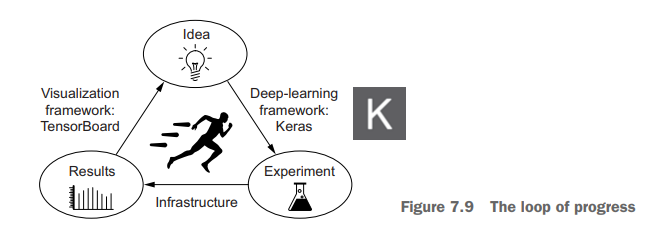

This section introduces TensorBoard, a browser-based visualization tool that comes
packaged with TensorFlow. Note that it’s only available for Keras models when we’re
using Keras with the TensorFlow backend.
 
The key purpose of TensorBoard is to help us visually monitor everything that
goes on inside our model during training. If we’re monitoring more information
than just the model’s final loss, we can develop a clearer vision of what the model
does and doesn’t do, and we can make progress more quickly. TensorBoard gives us
access to several neat features, all in our browser:

* Visually monitoring metrics during training
* Visualizing our model architecture
* Visualizing histograms of activations and gradients
* Exploring embeddings in 3D

Let’s demonstrate these features on a simple example. We’ll train a 1D convnet on
the IMDB sentiment-analysis task.
 
The model is similar to the one we saw in the last section of chapter 6. We’ll consider only the top 2,000 words in the IMDB vocabulary, to make visualizing word embeddings more tractable.

In [8]:
# Text-classification model to use with TensorBoard

import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 2000 # Number of words to consider as features
max_len = 500 # Cuts off texts after this number of words (among max_features most common words)

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

In [9]:
model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(max_features, 128,input_length=max_len,name='embed'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 500, 128)          256000    
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 291,937
Trainable params: 291,937
Non-trainable params: 0
__________________________________________________

In [10]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

Before we start using TensorBoard, we need to create a directory where we’ll store
the log files it generates.

In [14]:
# Creating a directory for TensorBoard log files

import os

os.mkdir("my_log_dir")

Let’s launch the training with a TensorBoard callback instance. This callback will write
log events to disk at the specified location.

In [15]:
# Training the model with a TensorBoard callback

callbacks = [
keras.callbacks.TensorBoard(
log_dir='my_log_dir', # Log files will be written at this location.
histogram_freq=1, # Records activation histograms every 1 epoch
embeddings_freq=1, # Records embedding data every 1 epoch
)]

In [ ]:
history = model.fit(x_train, y_train,epochs=20,batch_size=128,
                    validation_split=0.2,callbacks=callbacks)

Epoch 1/20
157/157 [==============================] - 82s 482ms/step - loss: 0.7765 - acc: 0.5583 - val_loss: 0.4799 - val_acc: 0.8184
Epoch 2/20
157/157 [==============================] - 81s 516ms/step - loss: 0.4412 - acc: 0.8443 - val_loss: 0.4236 - val_acc: 0.8606
Epoch 3/20
157/157 [==============================] - 80s 508ms/step - loss: 0.3705 - acc: 0.8794 - val_loss: 0.4567 - val_acc: 0.8610
Epoch 4/20
157/157 [==============================] - 92s 585ms/step - loss: 0.3321 - acc: 0.9033 - val_loss: 0.6859 - val_acc: 0.8302
Epoch 5/20
157/157 [==============================] - 89s 569ms/step - loss: 0.2945 - acc: 0.9176 - val_loss: 0.5210 - val_acc: 0.8626
Epoch 6/20
157/157 [==============================] - 98s 620ms/step - loss: 0.2459 - acc: 0.9429 - val_loss: 0.5981 - val_acc: 0.8664
Epoch 7/20
157/157 [==============================] - 100s 634ms/step - loss: 0.2201 - acc: 0.9513 - val_loss: 0.9388 - val_acc: 0.8312
Epoch 8/20
157/157 [==============================] - 

At this point, we can launch the TensorBoard server from the command line,
instructing it to read the logs the callback is currently writing. The tensorboard utility
should have been automatically installed on our machine the moment we installed
TensorFlow (for example, via pip):

`$ tensorboard --logdir=my_log_dir`

We can then browse to http://localhost:6006 and look at our model training

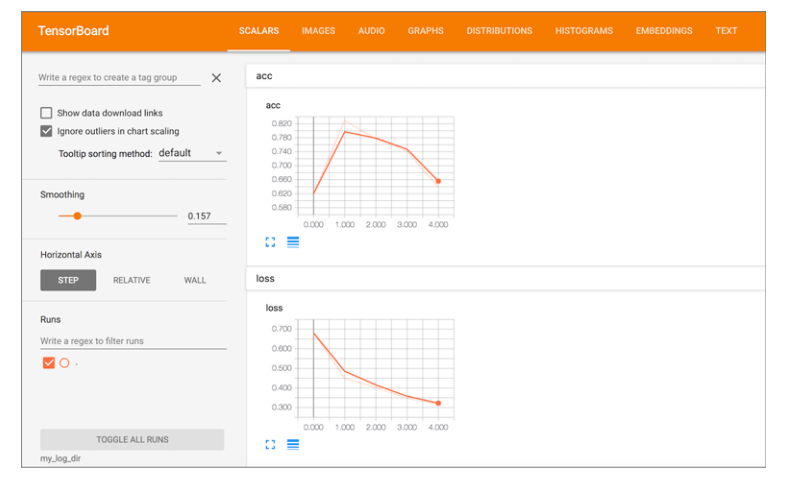

In addition to live graphs of the training and validation metrics, we get
access to the Histograms tab, where we can find pretty visualizations of histograms of
activation values taken by our layers.

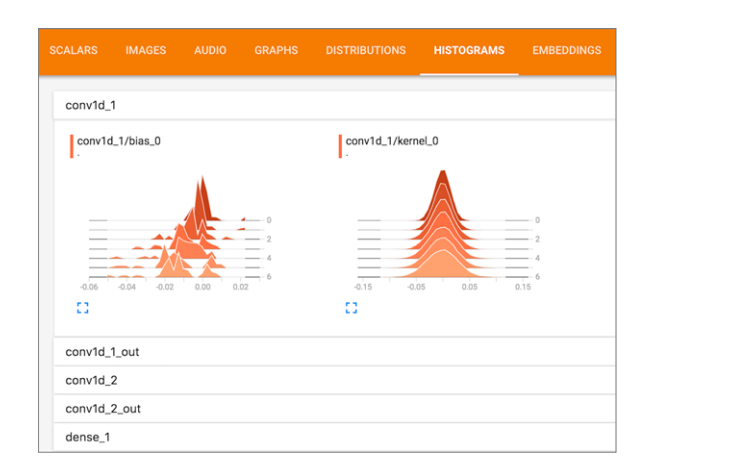

The Embeddings tab gives us a way to inspect the embedding locations and spatial
relationships of the 10,000 words in the input vocabulary, as learned by the initial
Embedding layer. 

Because the embedding space is 128-dimensional, TensorBoard automatically reduces it to 2D or 3D using a dimensionality-reduction algorithm of our
choice: either 
* principal component analysis (PCA) or 
* t-distributed stochastic neighbor embedding (t-SNE). 

In figure below, in the point cloud, we can clearly see two clusters:
* words with a positive connotation and 
* words with a negative connotation. 

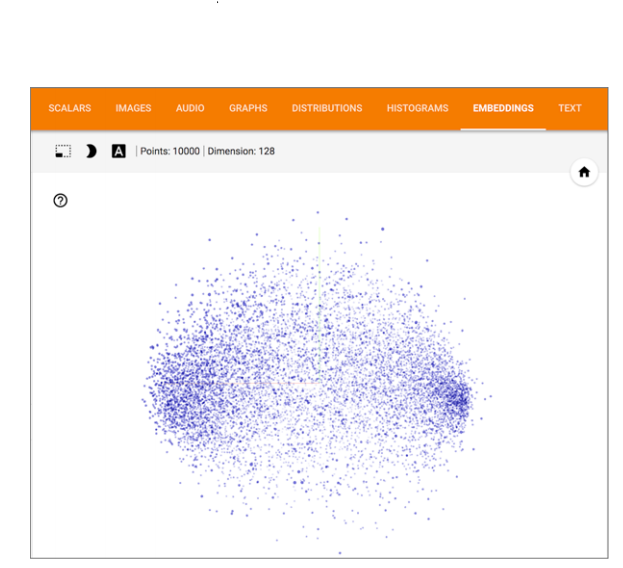

The visualization makes it immediately obvious that embeddings trained jointly with a specific
objective result in models that are completely specific to the underlying task—that’s
the reason using pretrained generic word embeddings is rarely a good idea.

The Graphs tab shows an interactive visualization of the graph of low-level TensorFlow
operations underlying our Keras model.

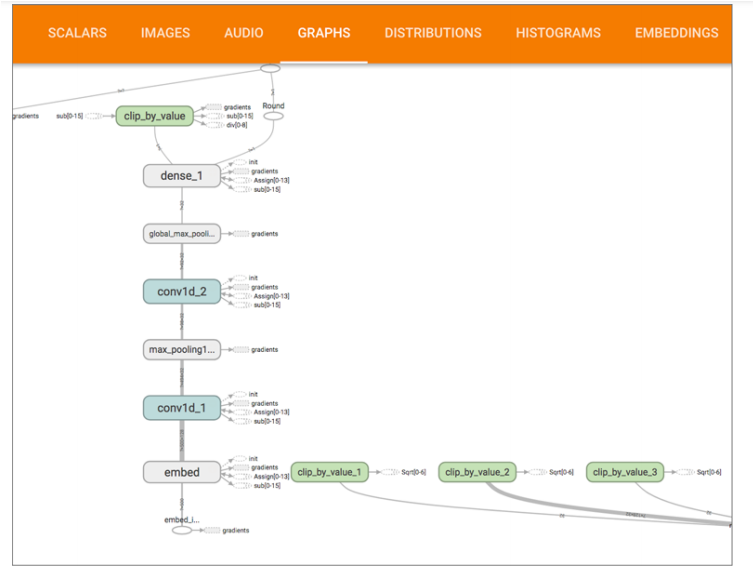


As we can see, there’s a lot
more going on than we would expect. The model we just built may look simple
when defined in Keras—a small stack of basic layers—but under the hood, we need
to construct a fairly complex graph structure to make it work. 

A lot of it is related to
the gradient-descent process. This complexity differential between what we see and
what we’re manipulating is the key motivation for using Keras as our way of building
models, instead of working with raw TensorFlow to define everything from scratch.
Keras makes our workflow dramatically simpler.

Note that Keras also provides another, cleaner way to plot models as graphs of layers
rather than graphs of TensorFlow operations: the utility `keras.utils.plot_model`.

Using it requires that we’ve installed the Python `pydot` and `pydot-ng` libraries as well
as the `graphviz` library. Let’s take a quick look:

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

This creates the PNG image shown in figure below.

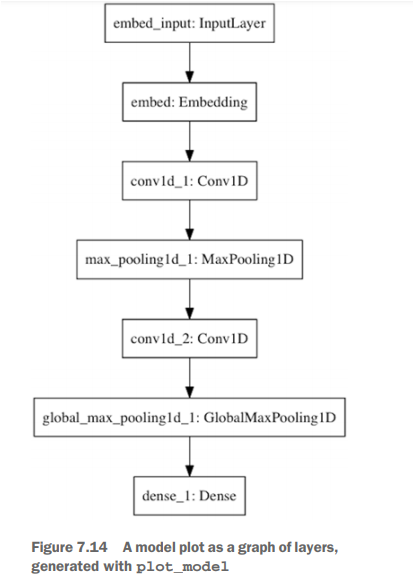

We also have the option of displaying shape information in the graph of layers. This
example visualizes model topology using `plot_model` and the `show_shapes` option

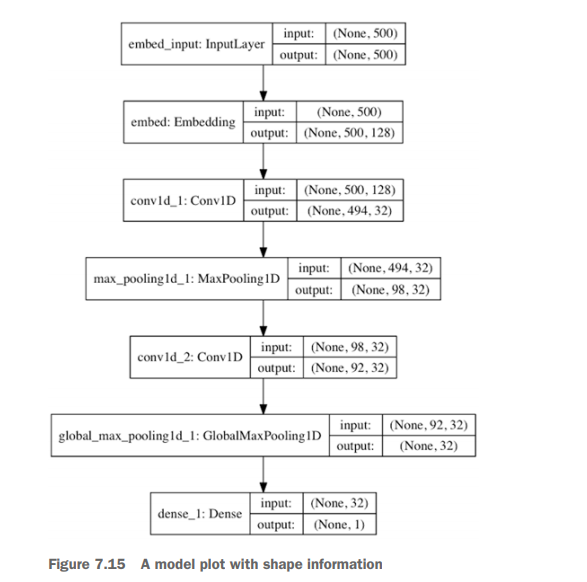

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')

### Conclusion

* Keras callbacks provide a simple way to monitor models during training and automatically take action based on the state of the model.
* When we’re using TensorFlow, TensorBoard is a great way to visualize model activity in our browser. We can use it in Keras models via the TensorBoard callback. 